In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
!pip install matplotlib==3.3.3

# modules

In [ ]:
import sys
import os
from copy import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mlt
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import collections

import cv2
import time
import itertools
import random

from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, zero_one_loss, roc_curve, auc, roc_auc_score, f1_score, precision_score, recall_score
import sklearn as sk

In [ ]:
mlt.__version__

'3.3.3'

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [ ]:
import tensorflow.keras as keras

from tensorflow.keras import layers, models, optimizers

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Concatenate, Dot, Lambda, Input, Dropout,ZeroPadding2D, Activation, concatenate, BatchNormalization, Conv1D, GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import optimizers

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

from tensorflow.keras import backend as K

In [ ]:
tf.__version__

'2.5.0'

# datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/graduation\ project\ \(ML\)/datasets/BHSig260.zip

In [ ]:
!unzip /content/drive/MyDrive/graduation\ project\ \(ML\)/datasets/cedar55.zip

In [ ]:
!unzip /content/drive/MyDrive/graduation\ project\ \(ML\)/datasets/Dutch10.zip

In [ ]:
!unzip /content/drive/MyDrive/graduation\ project\ \(ML\)/datasets/kaggle30.zip

# Model

In [ ]:
siamese_net = keras.models.load_model(r"/content/drive/MyDrive/graduation project (ML)/model_5/Train 11/model_34.h5")

In [ ]:
print(siamese_net.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 300, 1) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 150, 300, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 69120)        18315712    input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 69120)        0           sequential[0][0]             

In [ ]:
img_h, img_w, img_ch = 150, 300, 1
image_shape = (img_h, img_w, img_ch)
image_shape

(150, 300, 1)

In [ ]:
path_y = r"/content/drive/MyDrive/graduation project (ML)/results/"

# BHSIG260 - Hindi

### get path of images

In [ ]:
path = "/content/BHSig260/Hindi/"

In [ ]:
dir_list = next(os.walk(path))[1]
dir_list.sort(reverse=False)
# dir_list.sort()
len(dir_list)

160

In [ ]:
orig_groups, forg_groups = [], []
for i,directory in enumerate(dir_list):
  # if i==10:
  #   break
  images = os.listdir(path+directory)
  images.sort()
  images = [path+directory+'/'+x for x in images]
  forg_groups.append(images[:30]) 
  orig_groups.append(images[30:]) 

In [ ]:
print(len(orig_groups))
print(len(forg_groups))
print(len(orig_groups[0]))
print(len(forg_groups[0]))

160
160
24
30


In [ ]:
orig_lengths = [len(x) for x in orig_groups]
forg_lengths = [len(x) for x in forg_groups]
print(orig_lengths)
print(forg_lengths)

[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]
[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30

### preprocessor_img and generate_batch



In [ ]:
kernel = np.ones((9,9),np.uint8) # default
def preprocessor_img(path, image_shape):
  image = cv2.imread(path,0)
  blured = cv2.GaussianBlur(image, (9,9), 0)
  threshold, binary = cv2.threshold(blured, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
  closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=30)
  contours, hierarchies = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  the_biggest_contour_by_area = max(contours, key=cv2.contourArea) 
  x,y,w,h = cv2.boundingRect(the_biggest_contour_by_area)
  cropped = image[y:y+h, x:x+w]
  resized = cv2.resize(cropped, image_shape, interpolation=cv2.INTER_LANCZOS4)
  # resized_blured = cv2.GaussianBlur(resized, (9,9), 0)
  threshold, resized_binary = cv2.threshold(resized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  return resized_binary

In [ ]:
num_samples = 0
y_true = 0

In [ ]:
def generate_batch(orig_data, forg_data, batch_size = 32):

  global num_samples, y_true

  orig_pairs = []
  forg_pairs = []
  gen_gen_labels = []
  gen_for_labels = []
  all_pairs = []
  all_labels = []

  for orig, forg in zip(orig_data, forg_data):
      orig_pairs.extend(list(itertools.combinations(orig, 2)))
      for i in range(len(forg)):
        forg_pairs.extend(list(itertools.product(orig[i:i+1], random.sample(forg, len(forg)))))
  
  # Label for Genuine-Genuine pairs is 1
  # Label for Genuine-Forged pairs is 0
  gen_gen_labels = [1]*len(orig_pairs)
  gen_for_labels = [0]*len(forg_pairs)
  
  # Concatenate all the pairs together along with their labels and shuffle them
  all_pairs = orig_pairs + forg_pairs
  all_labels = gen_gen_labels + gen_for_labels
  del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
  all_pairs, all_labels = shuffle(all_pairs, all_labels)

  # print(len(all_pairs))
  # pairss = all_pairs
  num_samples = len(all_pairs) 
  y_true = all_labels

  k = 0
  pairs=[np.zeros((batch_size, img_h, img_w, img_ch)) for i in range(2)]
  targets=np.zeros((batch_size,))

  for ix, pair in enumerate(all_pairs):
      img1 = preprocessor_img(pair[0], (img_w, img_h))
      img2 = preprocessor_img(pair[1], (img_w, img_h))
      # img1 = cv2.imread(pair[0],0)
      # img2 = cv2.imread(pair[1],0)
      # img1 = cv2.resize(img1, (img_w, img_h), interpolation=cv2.INTER_LANCZOS4)
      # img2 = cv2.resize(img2, (img_w, img_h), interpolation=cv2.INTER_LANCZOS4)
      img1 = img1.astype('float32')
      img2 = img2.astype('float32')
      img1 /= 255
      img2 /= 255
      img1 = np.atleast_3d(img1)
      img2 = np.atleast_3d(img2)
      # img2 = img2[...,np.newaxis]
      pairs[0][k, :, :, :] = img1
      pairs[1][k, :, :, :] = img2
      targets[k] = all_labels[ix]

      k += 1
      if k == batch_size:
          # yield np.array(pairs), np.array(targets)
          yield pairs, targets
          k = 0
          pairs=[np.zeros((batch_size, img_h, img_w, img_ch)) for i in range(2)]
          targets=np.zeros((batch_size,))

### visualize generate_batch



In [ ]:
ff = generate_batch(orig_groups, forg_groups, batch_size = 32)


pairs, targets = next(ff)
pairs, targets = np.array(pairs), np.array(targets)

In [ ]:
pairs.shape, targets.shape

((2, 32, 150, 300, 1), (32,))

In [ ]:
targets

array([0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.])

0.0


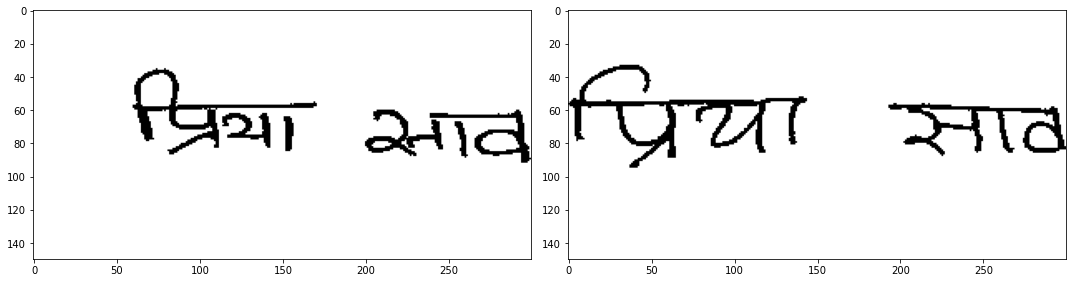

In [ ]:
i = 2

print(targets[i])

plt.figure(figsize = (15, 10))
plt.subplot(121)
plt.imshow(pairs[0][i],'gray')
plt.subplot(122)
plt.imshow(pairs[1][i],'gray')
plt.tight_layout()
plt.show()

### evaluate
 

In [ ]:
batch_sz = 120
num_samples

159360

In [ ]:
num_samples/batch_sz

1328.0

In [ ]:
# ev = siamese_net.evaluate(
#                             generate_batch(orig_groups, forg_groups, batch_size = batch_sz), 
#                             steps = num_samples//batch_sz,
#                             )
# ev

In [ ]:
y_pred = siamese_net.predict(
                                      generate_batch(orig_groups, forg_groups, batch_size = batch_sz), 
                                      steps = num_samples//batch_sz,
                                      verbose=1,
                                      )

1328/1328 [==============================] - 3216s 2s/step


In [ ]:
pickle.dump( y_pred, open(path_y + "y_pred_hindi.pickle",'wb') )

In [ ]:
y_pred = pickle.load(open(path_y + "y_pred_hindi.pickle",'rb'))

In [ ]:
y_pred

array([[2.8493893e-01],
       [8.6131769e-01],
       [8.3044998e-02],
       ...,
       [4.5840070e-06],
       [3.1363018e-04],
       [3.7042382e-06]], dtype=float32)

In [ ]:
# y_pred_round = np.where(y_pred > 0.75, 1, 0).flatten()
y_pred_round = y_pred.round().flatten().astype('int')

In [ ]:
y_true = np.array(y_true)

In [ ]:
y_pred_round

array([0, 1, 0, ..., 0, 0, 0])

In [ ]:
y_true

array([1, 0, 0, ..., 0, 0, 0])

In [ ]:
# data = {}
# data['y_pred'] = y_pred
# data['y_pred_round'] = y_pred_round
# data['y_true'] = y_true

# pickle.dump( data, open(path_y + "y_hindi.pickle",'wb') )

In [ ]:
data = pickle.load(open(path_y + "y_hindi.pickle",'rb'))

In [ ]:
y_pred_round , y_true = data['y_pred_round'], data['y_true']

In [ ]:
y_true.shape, y_true[y_true==0].shape , y_true[y_true==1].shape

((159360,), (115200,), (44160,))

In [ ]:
cm = confusion_matrix(y_true, y_pred_round)
cm

array([[100838,  14362],
       [ 10290,  33870]])

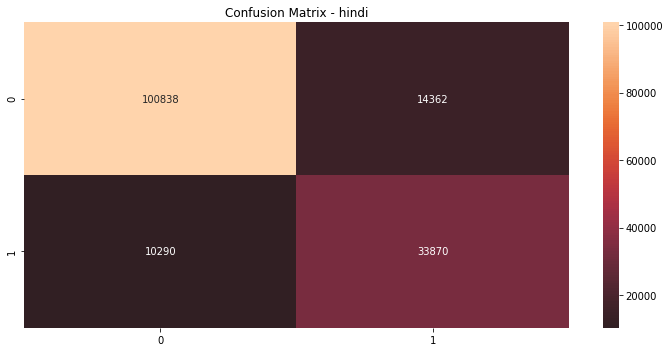

In [ ]:
# drawing confusion matrix
plt.figure(figsize=(10,5))
sns.heatmap(cm, center = True, annot=True, fmt="d")

plt.title('Confusion Matrix - hindi')
plt.tight_layout()

# save the figure
plt.savefig(path_y + "CM_hindi.png")


plt.show()

In [ ]:
accuracy = accuracy_score(y_true, y_pred_round)
print("Accuracy : ", accuracy*100, "%")

Accuracy :  84.53062248995984 %


In [ ]:
# f1 = f1_score(y_true, y_pred_round,  average='binary')
# print("f1 score : ", f1*100, "%")

In [ ]:
print(classification_report(y_true,y_pred_round,output_dict=False))

              precision    recall  f1-score   support

           0       0.91      0.88      0.89    115200
           1       0.70      0.77      0.73     44160

    accuracy                           0.85    159360
   macro avg       0.80      0.82      0.81    159360
weighted avg       0.85      0.85      0.85    159360



In [ ]:
cr = classification_report(y_true, y_pred_round, output_dict=True)
pd.DataFrame(cr).T

,precision,recall,f1-score,support
0,0.907404,0.875330,0.891078,115200.000000
1,0.702231,0.766984,0.733180,44160.000000
accuracy,0.845306,0.845306,0.845306,0.845306
macro avg,0.804817,0.821157,0.812129,159360.000000
weighted avg,0.850549,0.845306,0.847324,159360.000000


In [ ]:
ZeroOneLossValue = zero_one_loss(y_true, y_pred_round, normalize=False)
print('Wrong Value : ', ZeroOneLossValue )
ZeroOneLossValue = zero_one_loss(y_true, y_pred_round, normalize=True)
print('Wrong percentage : ', round(ZeroOneLossValue*100,2), "%" )

Wrong Value :  24652
Wrong percentage :  15.47 %


In [ ]:
fprValue, tprValue, thresholdsValue = roc_curve(y_true, y_pred_round)
print('False Postitve Rate Value : ', fprValue)
print('True Postitve Rate Value Value  : ', tprValue)
print('thresholds Value  : ', thresholdsValue)

False Postitve Rate Value :  [0.         0.12467014 1.        ]
True Postitve Rate Value Value  :  [0.        0.7669837 1.       ]
thresholds Value  :  [2 1 0]


In [ ]:
aucValue = auc(fprValue, tprValue)
aucValue2 = roc_auc_score(y_true, y_pred_round)
print('Area Under the Curve Value  : ', aucValue)
print('Area Under the Curve Value  : ', aucValue2)

Area Under the Curve Value  :  0.8211567783816425
Area Under the Curve Value  :  0.8211567783816425


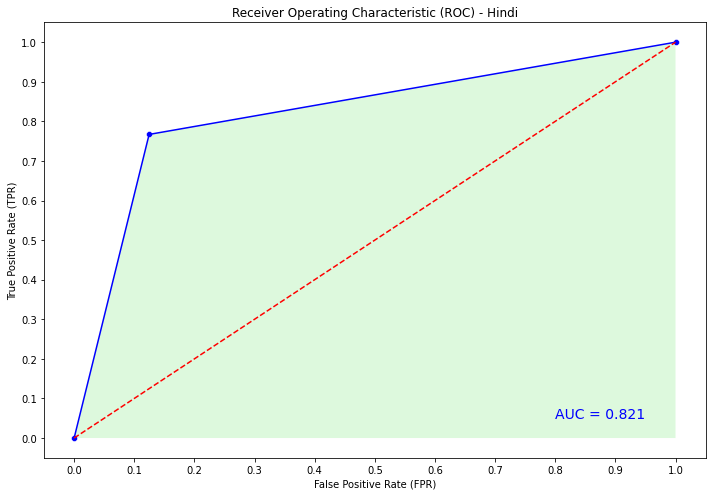

In [ ]:
plt.figure(figsize=(10,7))

sns.lineplot(x=fprValue, y=tprValue, color='blue');
sns.lineplot(x=[0, 1], y=[0, 1], color='red', linestyle='--')
plt.fill_between(fprValue, tprValue, facecolor='lightgreen', alpha=0.3)
plt.text(0.95, 0.05, f"AUC = {aucValue:0.3f}", ha='right', fontsize=14, color='blue')
# plt.scatter(fprValue,tprValue)
sns.scatterplot(x=fprValue, y=tprValue, color='blue', alpha=1);

plt.title('Receiver Operating Characteristic (ROC) - Hindi')
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')
plt.xticks(np.arange(0,1.1,0.1))
plt.yticks(np.arange(0,1.1,0.1))

# plt.xlim([0, 1])
# plt.ylim([0, 1])
plt.tight_layout()

# save the figure
plt.savefig(path_y + "ROC_Hindi.png")

plt.show() 

# BHSIG260 - Bengali

### get path of images

In [ ]:
path = "/content/BHSig260/Bengali/"

In [ ]:
dir_list = next(os.walk(path))[1]
dir_list.sort(reverse=False)
# dir_list.sort()
len(dir_list)

100

In [ ]:
orig_groups, forg_groups = [], []
for i,directory in enumerate(dir_list):
  # if i==10:
  #   break
  images = os.listdir(path+directory)
  images.sort()
  images = [path+directory+'/'+x for x in images]
  forg_groups.append(images[:30]) 
  orig_groups.append(images[30:]) 

In [ ]:
print(len(orig_groups))
print(len(forg_groups))
print(len(orig_groups[0]))
print(len(forg_groups[0]))

100
100
24
30


In [ ]:
orig_lengths = [len(x) for x in orig_groups]
forg_lengths = [len(x) for x in forg_groups]
print(orig_lengths)
print(forg_lengths)

[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]
[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]


### preprocessor_img and generate_batch


In [ ]:
kernel = np.ones((9,9),np.uint8) # default
def preprocessor_img(path, image_shape):
  image = cv2.imread(path,0)
  blured = cv2.GaussianBlur(image, (9,9), 0)
  threshold, binary = cv2.threshold(blured, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
  closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=30)
  contours, hierarchies = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  the_biggest_contour_by_area = max(contours, key=cv2.contourArea) 
  x,y,w,h = cv2.boundingRect(the_biggest_contour_by_area)
  cropped = image[y:y+h, x:x+w]
  resized = cv2.resize(cropped, image_shape, interpolation=cv2.INTER_LANCZOS4)
  # resized_blured = cv2.GaussianBlur(resized, (9,9), 0)
  threshold, resized_binary = cv2.threshold(resized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  return resized_binary

In [ ]:
num_samples = 0
y_true = 0

In [ ]:
def generate_batch(orig_data, forg_data, batch_size = 32):

  global num_samples, y_true

  orig_pairs = []
  forg_pairs = []
  gen_gen_labels = []
  gen_for_labels = []
  all_pairs = []
  all_labels = []

  for orig, forg in zip(orig_data, forg_data):
      orig_pairs.extend(list(itertools.combinations(orig, 2)))
      for i in range(len(forg)):
        forg_pairs.extend(list(itertools.product(orig[i:i+1], random.sample(forg, len(forg)))))
  
  # Label for Genuine-Genuine pairs is 1
  # Label for Genuine-Forged pairs is 0
  gen_gen_labels = [1]*len(orig_pairs)
  gen_for_labels = [0]*len(forg_pairs)
  
  # Concatenate all the pairs together along with their labels and shuffle them
  all_pairs = orig_pairs + forg_pairs
  all_labels = gen_gen_labels + gen_for_labels
  del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
  all_pairs, all_labels = shuffle(all_pairs, all_labels)

  # print(len(all_pairs))
  # pairss = all_pairs
  num_samples = len(all_pairs) 
  y_true = all_labels

  k = 0
  pairs=[np.zeros((batch_size, img_h, img_w, img_ch)) for i in range(2)]
  targets=np.zeros((batch_size,))

  for ix, pair in enumerate(all_pairs):
      img1 = preprocessor_img(pair[0], (img_w, img_h))
      img2 = preprocessor_img(pair[1], (img_w, img_h))
      # img1 = cv2.imread(pair[0],0)
      # img2 = cv2.imread(pair[1],0)
      # img1 = cv2.resize(img1, (img_w, img_h), interpolation=cv2.INTER_LANCZOS4)
      # img2 = cv2.resize(img2, (img_w, img_h), interpolation=cv2.INTER_LANCZOS4)
      img1 = img1.astype('float32')
      img2 = img2.astype('float32')
      img1 /= 255
      img2 /= 255
      img1 = np.atleast_3d(img1)
      img2 = np.atleast_3d(img2)
      # img2 = img2[...,np.newaxis]
      pairs[0][k, :, :, :] = img1
      pairs[1][k, :, :, :] = img2
      targets[k] = all_labels[ix]

      k += 1
      if k == batch_size:
          # yield np.array(pairs), np.array(targets)
          yield pairs, targets
          k = 0
          pairs=[np.zeros((batch_size, img_h, img_w, img_ch)) for i in range(2)]
          targets=np.zeros((batch_size,))

### visualize generate_batch


In [ ]:
ff = generate_batch(orig_groups, forg_groups, batch_size = 32)


pairs, targets = next(ff)
pairs, targets = np.array(pairs), np.array(targets)

In [ ]:
pairs.shape, targets.shape

((2, 32, 150, 300, 1), (32,))

In [ ]:
targets

array([0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.])

0.0


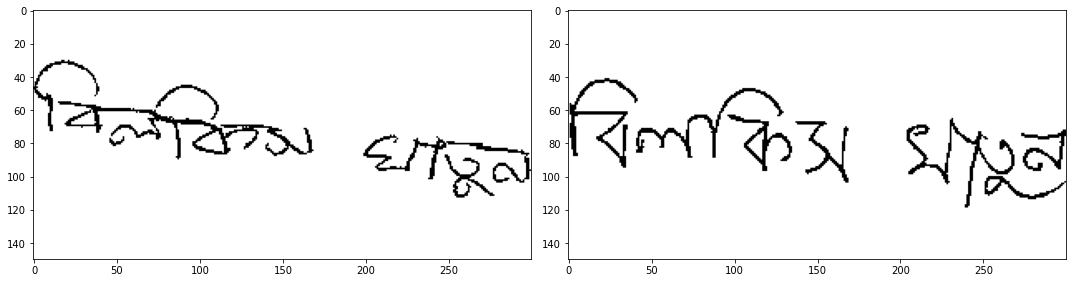

In [ ]:
i = 1

print(targets[i])

plt.figure(figsize = (15, 10))
plt.subplot(121)
plt.imshow(pairs[0][i],'gray')
plt.subplot(122)
plt.imshow(pairs[1][i],'gray')
plt.tight_layout()
plt.show()

### evaluate
 

In [ ]:
batch_sz = 100
num_samples

99600

In [ ]:
num_samples / batch_sz

996.0

In [ ]:
y_pred = siamese_net.predict(
                                      generate_batch(orig_groups, forg_groups, batch_size = batch_sz), 
                                      steps = num_samples/batch_sz,
                                      verbose=1,
                                      )

996/996 [==============================] - 2017s 2s/step


In [ ]:
pickle.dump( y_pred, open(path_y + "y_pred_bengali.pickle",'wb') )

In [ ]:
y_pred = pickle.load(open(path_y + "y_pred_bengali.pickle",'rb'))

In [ ]:
y_pred

array([[3.2786760e-02],
       [1.5879556e-04],
       [5.2798581e-01],
       ...,
       [2.8103491e-02],
       [9.4817460e-01],
       [2.3103201e-01]], dtype=float32)

In [ ]:
# y_pred_round = np.where(y_pred > 0.75, 1, 0).flatten()
y_pred_round = y_pred.round().flatten().astype('int')

In [ ]:
y_true = np.array(y_true)

In [ ]:
y_pred_round

array([0, 0, 1, ..., 0, 1, 0])

In [ ]:
y_true

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# data = {}
# data['y_pred'] = y_pred
# data['y_pred_round'] = y_pred_round
# data['y_true'] = y_true

# pickle.dump( data, open(path_y + "y_bengali.pickle",'wb') )

In [23]:
data = pickle.load(open(path_y + "y_bengali.pickle",'rb'))

In [24]:
y_pred_round , y_true = data['y_pred_round'], data['y_true']

In [25]:
y_true.shape, y_true[y_true==0].shape , y_true[y_true==1].shape

((99600,), (72000,), (27600,))

In [ ]:
cm = confusion_matrix(y_true, y_pred_round)
cm

array([[64915,  7085],
       [ 4653, 22947]])

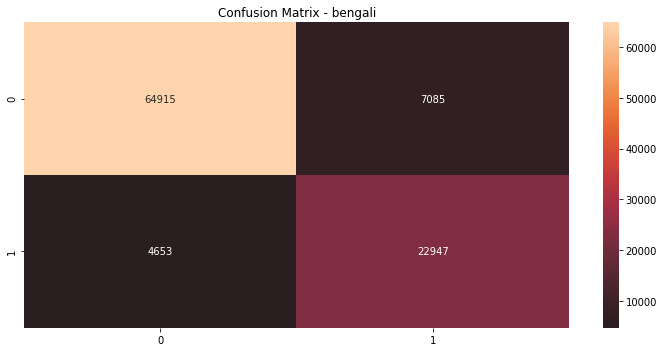

In [ ]:
# drawing confusion matrix
plt.figure(figsize=(10,5))
sns.heatmap(cm, center = True, annot=True, fmt="d")

plt.title('Confusion Matrix - bengali')
plt.tight_layout()

# save the figure
plt.savefig(path_y + "CM_bengali.png")


plt.show()

In [ ]:
accuracy = accuracy_score(y_true, y_pred_round)
print("Accuracy : ", accuracy*100, "%")

Accuracy :  88.214859437751 %


In [ ]:
print(classification_report(y_true,y_pred_round,output_dict=False))

              precision    recall  f1-score   support

           0       0.93      0.90      0.92     72000
           1       0.76      0.83      0.80     27600

    accuracy                           0.88     99600
   macro avg       0.85      0.87      0.86     99600
weighted avg       0.89      0.88      0.88     99600



In [ ]:
cr = classification_report(y_true, y_pred_round, output_dict=True)
pd.DataFrame(cr).T

,precision,recall,f1-score,support
0,0.933116,0.901597,0.917086,72000.000000
1,0.764085,0.831413,0.796328,27600.000000
accuracy,0.882149,0.882149,0.882149,0.882149
macro avg,0.848600,0.866505,0.856707,99600.000000
weighted avg,0.886276,0.882149,0.883623,99600.000000


In [ ]:
ZeroOneLossValue = zero_one_loss(y_true, y_pred_round, normalize=False)
print('Wrong Value : ', ZeroOneLossValue )
ZeroOneLossValue = zero_one_loss(y_true, y_pred_round, normalize=True)
print('Wrong percentage : ', round(ZeroOneLossValue*100,2), "%" )

Wrong Value :  11738
Wrong percentage :  11.79 %


In [ ]:
fprValue, tprValue, thresholdsValue = roc_curve(y_true, y_pred_round)
print('False Postitve Rate Value : ', fprValue)
print('True Postitve Rate Value Value  : ', tprValue)
print('thresholds Value  : ', thresholdsValue)

False Postitve Rate Value :  [0.         0.09840278 1.        ]
True Postitve Rate Value Value  :  [0.         0.83141304 1.        ]
thresholds Value  :  [2 1 0]


In [ ]:
aucValue = auc(fprValue, tprValue)
aucValue2 = roc_auc_score(y_true, y_pred_round)
print('Area Under the Curve Value  : ', aucValue)
print('Area Under the Curve Value  : ', aucValue2)

Area Under the Curve Value  :  0.8665051328502414
Area Under the Curve Value  :  0.8665051328502414


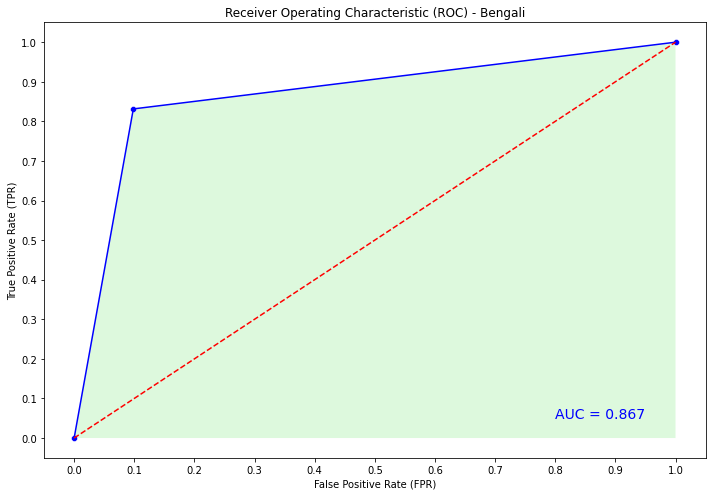

In [ ]:
plt.figure(figsize=(10,7))

sns.lineplot(x=fprValue, y=tprValue, color='blue');
sns.lineplot(x=[0, 1], y=[0, 1], color='red', linestyle='--')
plt.fill_between(fprValue, tprValue, facecolor='lightgreen', alpha=0.3)
plt.text(0.95, 0.05, f"AUC = {aucValue:0.3f}", ha='right', fontsize=14, color='blue')
# plt.scatter(fprValue,tprValue)
sns.scatterplot(x=fprValue, y=tprValue, color='blue', alpha=1);

plt.title('Receiver Operating Characteristic (ROC) - Bengali')
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')
plt.xticks(np.arange(0,1.1,0.1))
plt.yticks(np.arange(0,1.1,0.1))

# plt.xlim([0, 1])
# plt.ylim([0, 1])
plt.tight_layout()

# save the figure
plt.savefig(path_y + "ROC_Bengali.png")

plt.show() 

# Dutch


### get path of images

In [ ]:
path = "/content/dutch/"

In [ ]:
dir_list = next(os.walk(path))[1]
dir_list.sort(key = int)
len(dir_list)

10

In [ ]:
orig_groups, forg_groups = [], []
for i,directory in enumerate(dir_list):
  # if i==10:
  #   break
  images = os.listdir(path+directory)
  images.sort()
  images = [path+directory+'/'+x for x in images]
  forg_groups.append(images[:24]) 
  orig_groups.append(images[24:]) 

In [ ]:
print(len(forg_groups))
print(len(orig_groups))
print(len(forg_groups[0]))
print(len(orig_groups[0]))

10
10
24
12


In [ ]:
orig_lengths = [len(x) for x in orig_groups]
forg_lengths = [len(x) for x in forg_groups]
print(orig_lengths)
print(forg_lengths)

[12, 12, 12, 12, 12, 12, 12, 12, 12, 12]
[24, 24, 24, 24, 24, 24, 24, 24, 24, 24]


### preprocessor_img and generate_batch


In [ ]:
kernel = np.ones((9,9),np.uint8) # default
def preprocessor_img(path, image_shape):
  image = cv2.imread(path,0)
  blured = cv2.GaussianBlur(image, (9,9), 0)
  threshold, binary = cv2.threshold(blured, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
  closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=30)
  contours, hierarchies = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  the_biggest_contour_by_area = max(contours, key=cv2.contourArea) 
  x,y,w,h = cv2.boundingRect(the_biggest_contour_by_area)
  cropped = image[y:y+h, x:x+w]
  resized = cv2.resize(cropped, image_shape, interpolation=cv2.INTER_LANCZOS4)
  # resized_blured = cv2.GaussianBlur(resized, (9,9), 0)
  threshold, resized_binary = cv2.threshold(resized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  return resized_binary

In [ ]:
num_samples = 0
y_true = 0

In [ ]:
def generate_batch(orig_data, forg_data, batch_size = 32):

  global num_samples, y_true

  orig_pairs = []
  forg_pairs = []
  gen_gen_labels = []
  gen_for_labels = []
  all_pairs = []
  all_labels = []

  for orig, forg in zip(orig_data, forg_data):
      orig_pairs.extend(list(itertools.combinations(orig, 2)))
      for i in range(len(forg)):
        forg_pairs.extend(list(itertools.product(orig[i:i+1], random.sample(forg, len(forg)))))
  
  # Label for Genuine-Genuine pairs is 1
  # Label for Genuine-Forged pairs is 0
  gen_gen_labels = [1]*len(orig_pairs)
  gen_for_labels = [0]*len(forg_pairs)
  
  # Concatenate all the pairs together along with their labels and shuffle them
  all_pairs = orig_pairs + forg_pairs
  all_labels = gen_gen_labels + gen_for_labels
  del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
  all_pairs, all_labels = shuffle(all_pairs, all_labels)

  # print(len(all_pairs))
  # pairss = all_pairs
  num_samples = len(all_pairs) 
  y_true = all_labels

  k = 0
  pairs=[np.zeros((batch_size, img_h, img_w, img_ch)) for i in range(2)]
  targets=np.zeros((batch_size,))

  for ix, pair in enumerate(all_pairs):
      img1 = preprocessor_img(pair[0], (img_w, img_h))
      img2 = preprocessor_img(pair[1], (img_w, img_h))
      # img1 = cv2.imread(pair[0],0)
      # img2 = cv2.imread(pair[1],0)
      # img1 = cv2.resize(img1, (img_w, img_h), interpolation=cv2.INTER_LANCZOS4)
      # img2 = cv2.resize(img2, (img_w, img_h), interpolation=cv2.INTER_LANCZOS4)
      img1 = img1.astype('float32')
      img2 = img2.astype('float32')
      img1 /= 255
      img2 /= 255
      img1 = np.atleast_3d(img1)
      img2 = np.atleast_3d(img2)
      # img2 = img2[...,np.newaxis]
      pairs[0][k, :, :, :] = img1
      pairs[1][k, :, :, :] = img2
      targets[k] = all_labels[ix]

      k += 1
      if k == batch_size:
          # yield np.array(pairs), np.array(targets)
          yield pairs, targets
          k = 0
          pairs=[np.zeros((batch_size, img_h, img_w, img_ch)) for i in range(2)]
          targets=np.zeros((batch_size,))

### visualize generate_batch


In [ ]:
ff = generate_batch(orig_groups, forg_groups, batch_size = 32)


pairs, targets = next(ff)
pairs, targets = np.array(pairs), np.array(targets)

In [ ]:
pairs.shape, targets.shape

((2, 32, 150, 300, 1), (32,))

In [ ]:
targets

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.])

0.0


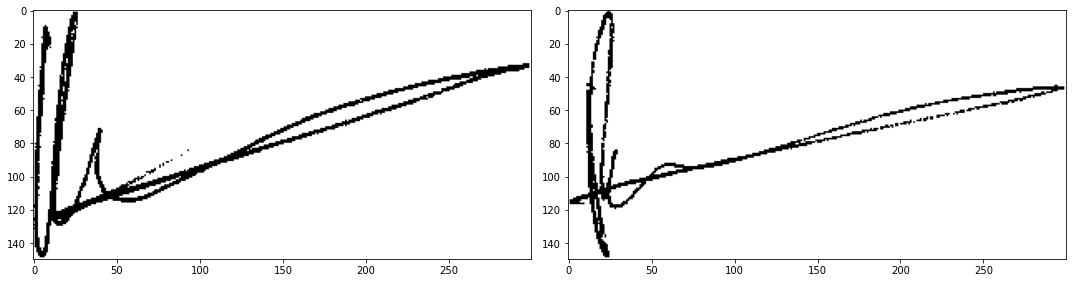

In [ ]:
i = 2

print(targets[i])

plt.figure(figsize = (15, 10))
plt.subplot(121)
plt.imshow(pairs[0][i],'gray')
plt.subplot(122)
plt.imshow(pairs[1][i],'gray')
plt.tight_layout()
plt.show()

### evaluate


In [ ]:
batch_sz = 60
num_samples

3540

In [ ]:
num_samples / batch_sz

59.0

In [ ]:
# dutch
ev = siamese_net.evaluate(
                            generate_batch(orig_groups, forg_groups, batch_size = batch_sz), 
                            steps = num_samples//batch_sz,
                            )
ev

59/59 [==============================] - 94s 2s/step - loss: 0.2611 - accuracy: 0.8949


[0.2611207962036133, 0.8949152827262878]

In [ ]:
y_pred = siamese_net.predict(
                                      generate_batch(orig_groups, forg_groups, batch_size = batch_sz), 
                                      steps = num_samples//batch_sz,
                                      verbose=1,
                                      )

59/59 [==============================] - 95s 1s/step


---

In [ ]:
pickle.dump( y_pred, open(path_y + "y_pred_dutch.pickle",'wb') )

In [ ]:
y_pred = pickle.load(open(path_y + "y_pred_dutch.pickle",'rb'))

In [ ]:
y_pred

array([[3.4198947e-02],
       [6.2541780e-08],
       [1.0125075e-06],
       ...,
       [1.4631406e-03],
       [9.3154885e-02],
       [5.3206426e-03]], dtype=float32)

In [ ]:
m = tf.keras.metrics.BinaryAccuracy()
m.update_state(y_true,y_pred)
m.result().numpy()

0.8949153

---

In [ ]:
# y_pred_round = np.where(y_pred > 0.75, 1, 0).flatten()
y_pred_round = y_pred.round().flatten().astype('int')

In [ ]:
y_true = np.array(y_true)

In [ ]:
y_pred_round

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
y_true

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# data = {}
# data['y_pred'] = y_pred
# data['y_pred_round'] = y_pred_round
# data['y_true'] = y_true

# pickle.dump( data, open(path_y + "y_dutch.pickle",'wb') )

In [26]:
data = pickle.load(open(path_y + "y_dutch.pickle",'rb'))

In [27]:
data.keys()

dict_keys(['y_pred', 'y_pred_round', 'y_true'])

In [28]:
y_pred_round , y_true = data['y_pred_round'], data['y_true']

In [29]:
y_true.shape, y_true[y_true==0].shape , y_true[y_true==1].shape

((3540,), (2880,), (660,))

---

In [ ]:
cm = confusion_matrix(y_true, y_pred_round)
cm

array([[2562,  318],
       [  54,  606]])

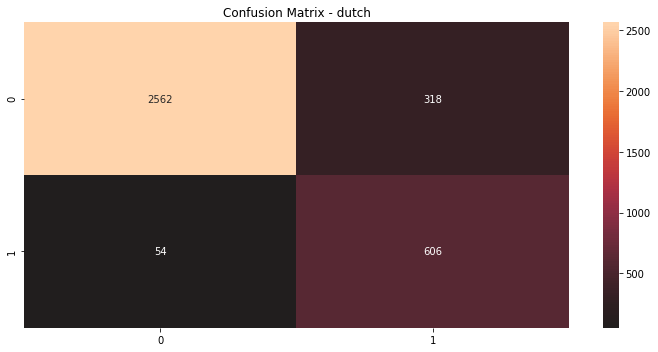

In [ ]:
# drawing confusion matrix
plt.figure(figsize=(10,5))
sns.heatmap(cm, center = True, annot=True, fmt="d")

plt.title('Confusion Matrix - dutch')
plt.tight_layout()

# save the figure
plt.savefig(path_y + "CM_dutch.png")


plt.show()

In [ ]:
accuracy = accuracy_score(y_true, y_pred_round)
print("Accuracy : ", accuracy*100, "%")

Accuracy :  89.49152542372882 %


In [ ]:
print(classification_report(y_true,y_pred_round,output_dict=False))

              precision    recall  f1-score   support

           0       0.98      0.89      0.93      2880
           1       0.66      0.92      0.77       660

    accuracy                           0.89      3540
   macro avg       0.82      0.90      0.85      3540
weighted avg       0.92      0.89      0.90      3540



In [ ]:
cr = classification_report(y_true, y_pred_round, output_dict=True)
pd.DataFrame(cr).T

,precision,recall,f1-score,support
0,0.979358,0.889583,0.932314,2880.000000
1,0.655844,0.918182,0.765152,660.000000
accuracy,0.894915,0.894915,0.894915,0.894915
macro avg,0.817601,0.903883,0.848733,3540.000000
weighted avg,0.919042,0.894915,0.901148,3540.000000


In [ ]:
ZeroOneLossValue = zero_one_loss(y_true, y_pred_round, normalize=False)
print('Wrong Value : ', ZeroOneLossValue )
ZeroOneLossValue = zero_one_loss(y_true, y_pred_round, normalize=True)
print('Wrong percentage : ', round(ZeroOneLossValue*100,2), "%" )

Wrong Value :  372
Wrong percentage :  10.51 %


In [ ]:
fprValue, tprValue, thresholdsValue = roc_curve(y_true, y_pred_round)
print('False Postitve Rate Value : ', fprValue)
print('True Postitve Rate Value Value  : ', tprValue)
print('thresholds Value  : ', thresholdsValue)

False Postitve Rate Value :  [0.         0.11041667 1.        ]
True Postitve Rate Value Value  :  [0.         0.91818182 1.        ]
thresholds Value  :  [2 1 0]


In [ ]:
aucValue = auc(fprValue, tprValue)
aucValue2 = roc_auc_score(y_true, y_pred_round)
print('Area Under the Curve Value  : ', aucValue)
print('Area Under the Curve Value  : ', aucValue2)

Area Under the Curve Value  :  0.9038825757575758
Area Under the Curve Value  :  0.9038825757575758


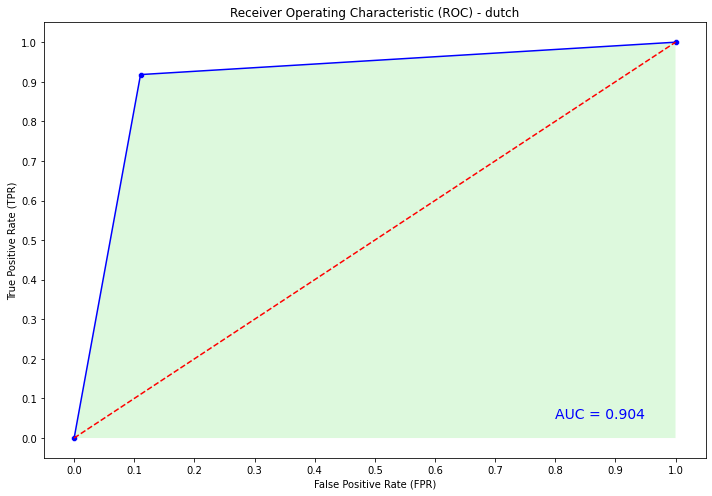

In [ ]:
plt.figure(figsize=(10,7))

sns.lineplot(x=fprValue, y=tprValue, color='blue');
sns.lineplot(x=[0, 1], y=[0, 1], color='red', linestyle='--')
plt.fill_between(fprValue, tprValue, facecolor='lightgreen', alpha=0.3)
plt.text(0.95, 0.05, f"AUC = {aucValue:0.3f}", ha='right', fontsize=14, color='blue')
# plt.scatter(fprValue,tprValue)
sns.scatterplot(x=fprValue, y=tprValue, color='blue', alpha=1);

plt.title('Receiver Operating Characteristic (ROC) - dutch')
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')
plt.xticks(np.arange(0,1.1,0.1))
plt.yticks(np.arange(0,1.1,0.1))

# plt.xlim([0, 1])
# plt.ylim([0, 1])
plt.tight_layout()

# save the figure
plt.savefig(path_y + "ROC_Dutch.png")

plt.show() 

# Kaggle


### get path of images

In [ ]:
path = "/content/kaggle30/"

In [ ]:
dir_list = next(os.walk(path))[1]
dir_list.sort(reverse=False)
# dir_list.sort()
len(dir_list)

30

In [ ]:
orig_groups, forg_groups = [], []
for i,directory in enumerate(dir_list):
  # if i==10:
  #   break
  images = os.listdir(path+directory)
  images.sort()
  images = [path+directory+'/'+x for x in images]
  forg_groups.append(images[:5]) 
  orig_groups.append(images[5:]) 

In [ ]:
print(len(forg_groups))
print(len(orig_groups))
print(len(forg_groups[0]))
print(len(orig_groups[0]))

30
30
5
5


In [ ]:
orig_lengths = [len(x) for x in orig_groups]
forg_lengths = [len(x) for x in forg_groups]
print(orig_lengths)
print(forg_lengths)

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


### preprocessor_img and generate_batch


In [ ]:
kernel = np.ones((9,9),np.uint8) # default
def preprocessor_img(path, image_shape):
  image = cv2.imread(path,0)
  blured = cv2.GaussianBlur(image, (9,9), 0)
  threshold, binary = cv2.threshold(blured, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
  closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=30)
  contours, hierarchies = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  the_biggest_contour_by_area = max(contours, key=cv2.contourArea) 
  x,y,w,h = cv2.boundingRect(the_biggest_contour_by_area)
  cropped = image[y:y+h, x:x+w]
  resized = cv2.resize(cropped, image_shape, interpolation=cv2.INTER_LANCZOS4)
  # resized_blured = cv2.GaussianBlur(resized, (9,9), 0)
  threshold, resized_binary = cv2.threshold(resized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  return resized_binary

In [ ]:
num_samples = 0
y_true = 0

In [ ]:
def generate_batch(orig_data, forg_data, batch_size = 32):

  global num_samples, y_true

  orig_pairs = []
  forg_pairs = []
  gen_gen_labels = []
  gen_for_labels = []
  all_pairs = []
  all_labels = []

  for orig, forg in zip(orig_data, forg_data):
      orig_pairs.extend(list(itertools.combinations(orig, 2)))
      for i in range(len(forg)):
        forg_pairs.extend(list(itertools.product(orig[i:i+1], random.sample(forg, len(forg)))))
  
  # Label for Genuine-Genuine pairs is 1
  # Label for Genuine-Forged pairs is 0
  gen_gen_labels = [1]*len(orig_pairs)
  gen_for_labels = [0]*len(forg_pairs)
  
  # Concatenate all the pairs together along with their labels and shuffle them
  all_pairs = orig_pairs + forg_pairs
  all_labels = gen_gen_labels + gen_for_labels
  del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
  all_pairs, all_labels = shuffle(all_pairs, all_labels)

  # print(len(all_pairs))
  # pairss = all_pairs
  num_samples = len(all_pairs) 
  y_true = all_labels

  k = 0
  pairs=[np.zeros((batch_size, img_h, img_w, img_ch)) for i in range(2)]
  targets=np.zeros((batch_size,))

  for ix, pair in enumerate(all_pairs):
      img1 = preprocessor_img(pair[0], (img_w, img_h))
      img2 = preprocessor_img(pair[1], (img_w, img_h))
      # img1 = cv2.imread(pair[0],0)
      # img2 = cv2.imread(pair[1],0)
      # img1 = cv2.resize(img1, (img_w, img_h), interpolation=cv2.INTER_LANCZOS4)
      # img2 = cv2.resize(img2, (img_w, img_h), interpolation=cv2.INTER_LANCZOS4)
      img1 = img1.astype('float32')
      img2 = img2.astype('float32')
      img1 /= 255
      img2 /= 255
      img1 = np.atleast_3d(img1)
      img2 = np.atleast_3d(img2)
      # img2 = img2[...,np.newaxis]
      pairs[0][k, :, :, :] = img1
      pairs[1][k, :, :, :] = img2
      targets[k] = all_labels[ix]

      k += 1
      if k == batch_size:
          # yield np.array(pairs), np.array(targets)
          yield pairs, targets
          k = 0
          pairs=[np.zeros((batch_size, img_h, img_w, img_ch)) for i in range(2)]
          targets=np.zeros((batch_size,))

### visualize generate_batch


In [ ]:
ff = generate_batch(orig_groups, forg_groups, batch_size = 32)


pairs, targets = next(ff)
pairs, targets = np.array(pairs), np.array(targets)

In [ ]:
pairs.shape, targets.shape

((2, 32, 150, 300, 1), (32,))

In [ ]:
targets

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
       1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

0.0


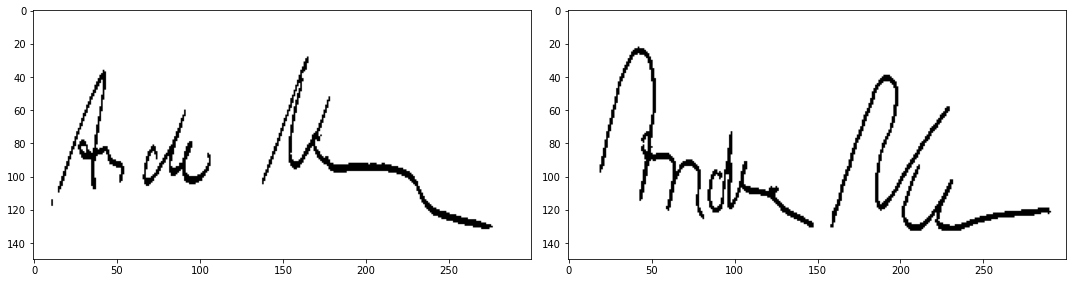

In [ ]:
i = 0

print(targets[i])

plt.figure(figsize = (15, 10))
plt.subplot(121)
plt.imshow(pairs[0][i],'gray')
plt.subplot(122)
plt.imshow(pairs[1][i],'gray')
plt.tight_layout()
plt.show()

### evaluate


In [ ]:
batch_sz = 50
num_samples

1050

In [ ]:
num_samples / batch_sz

21.0

In [ ]:
# kaggle30
ev = siamese_net.evaluate(
                            generate_batch(orig_groups, forg_groups, batch_size = batch_sz), 
                            steps = num_samples//batch_sz,
                            )
ev

21/21 [==============================] - 99s 3s/step - loss: 0.2589 - accuracy: 0.8981


[0.2588735818862915, 0.8980952501296997]

In [ ]:
y_pred = siamese_net.predict(
                                      generate_batch(orig_groups, forg_groups, batch_size = batch_sz), 
                                      steps = num_samples//batch_sz,
                                      verbose=1,
                                      )

21/21 [==============================] - 59s 3s/step


In [ ]:
pickle.dump( y_pred, open(path_y + "y_pred_kaggle.pickle",'wb') )

In [ ]:
y_pred = pickle.load(open(path_y + "y_pred_kaggle.pickle",'rb'))

In [ ]:
y_pred

array([[9.7009552e-01],
       [1.9692570e-07],
       [9.5478847e-04],
       ...,
       [1.8892116e-04],
       [5.0426077e-02],
       [7.4881065e-04]], dtype=float32)

In [ ]:
# y_pred_round = np.where(y_pred > 0.75, 1, 0).flatten()
y_pred_round = y_pred.round().flatten().astype('int')

In [ ]:
y_true = np.array(y_true)

In [ ]:
y_pred_round

array([1, 0, 0, ..., 0, 0, 0])

In [ ]:
y_true

array([1, 0, 0, ..., 0, 0, 0])

In [ ]:
# data = {}
# data['y_pred'] = y_pred
# data['y_pred_round'] = y_pred_round
# data['y_true'] = y_true

# pickle.dump( data, open(path_y + "y_kaggle.pickle",'wb') )

In [30]:
data = pickle.load(open(path_y + "y_kaggle.pickle",'rb'))

In [31]:
y_pred_round , y_true = data['y_pred_round'], data['y_true']

In [32]:
y_true.shape, y_true[y_true==0].shape , y_true[y_true==1].shape

((1050,), (750,), (300,))

In [ ]:
cm = confusion_matrix(y_true, y_pred_round)
cm

array([[708,  42],
       [ 65, 235]])

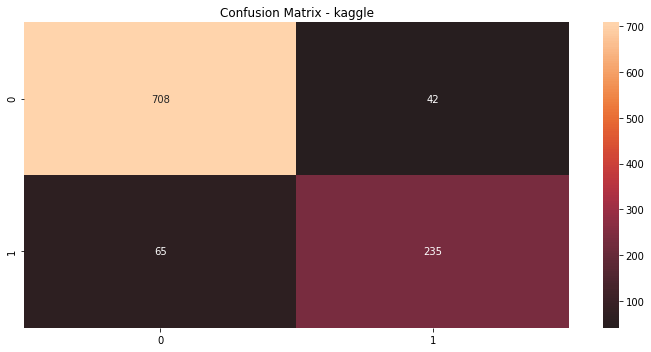

In [ ]:
# drawing confusion matrix
plt.figure(figsize=(10,5))
sns.heatmap(cm, center = True, annot=True, fmt="d")

plt.title('Confusion Matrix - kaggle')
plt.tight_layout()

# save the figure
plt.savefig(path_y + "CM_kaggle.png")


plt.show()

In [ ]:
accuracy = accuracy_score(y_true, y_pred_round)
print("Accuracy : ", accuracy*100, "%")

Accuracy :  89.80952380952381 %


In [ ]:
print(classification_report(y_true,y_pred_round,output_dict=False))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       750
           1       0.85      0.78      0.81       300

    accuracy                           0.90      1050
   macro avg       0.88      0.86      0.87      1050
weighted avg       0.90      0.90      0.90      1050



In [ ]:
cr = classification_report(y_true, y_pred_round, output_dict=True)
pd.DataFrame(cr).T

,precision,recall,f1-score,support
0,0.915912,0.944000,0.929744,750.000000
1,0.848375,0.783333,0.814558,300.000000
accuracy,0.898095,0.898095,0.898095,0.898095
macro avg,0.882144,0.863667,0.872151,1050.000000
weighted avg,0.896616,0.898095,0.896834,1050.000000


In [ ]:
ZeroOneLossValue = zero_one_loss(y_true, y_pred_round, normalize=False)
print('Wrong Value : ', ZeroOneLossValue )
ZeroOneLossValue = zero_one_loss(y_true, y_pred_round, normalize=True)
print('Wrong percentage : ', round(ZeroOneLossValue*100,2), "%" )

Wrong Value :  107
Wrong percentage :  10.19 %


In [ ]:
fprValue, tprValue, thresholdsValue = roc_curve(y_true, y_pred_round)
print('False Postitve Rate Value : ', fprValue)
print('True Postitve Rate Value Value  : ', tprValue)
print('thresholds Value  : ', thresholdsValue)

False Postitve Rate Value :  [0.    0.056 1.   ]
True Postitve Rate Value Value  :  [0.         0.78333333 1.        ]
thresholds Value  :  [2 1 0]


In [ ]:
aucValue = auc(fprValue, tprValue)
aucValue2 = roc_auc_score(y_true, y_pred_round)
print('Area Under the Curve Value  : ', aucValue)
print('Area Under the Curve Value  : ', aucValue2)

Area Under the Curve Value  :  0.8636666666666666
Area Under the Curve Value  :  0.8636666666666666


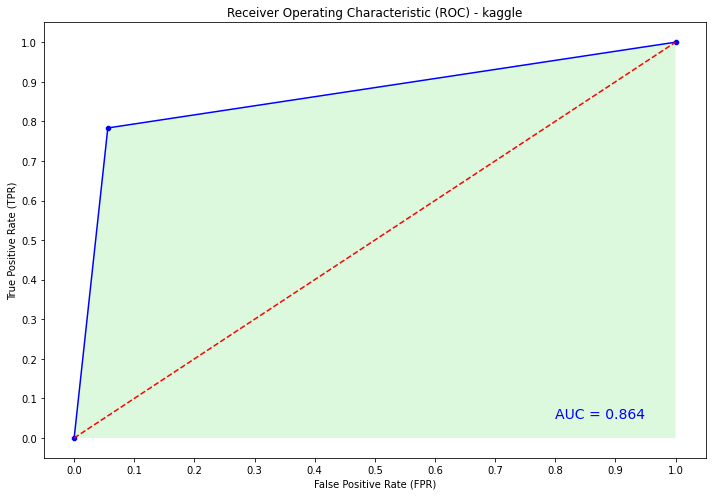

In [ ]:
plt.figure(figsize=(10,7))

sns.lineplot(x=fprValue, y=tprValue, color='blue');
sns.lineplot(x=[0, 1], y=[0, 1], color='red', linestyle='--')
plt.fill_between(fprValue, tprValue, facecolor='lightgreen', alpha=0.3)
plt.text(0.95, 0.05, f"AUC = {aucValue:0.3f}", ha='right', fontsize=14, color='blue')
# plt.scatter(fprValue,tprValue)
sns.scatterplot(x=fprValue, y=tprValue, color='blue', alpha=1);

plt.title('Receiver Operating Characteristic (ROC) - kaggle')
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')
plt.xticks(np.arange(0,1.1,0.1))
plt.yticks(np.arange(0,1.1,0.1))

# plt.xlim([0, 1])
# plt.ylim([0, 1])
plt.tight_layout()

# save the figure
plt.savefig(path_y + "ROC_kaggle.png")

plt.show() 

# Cedar

### get path of images

In [ ]:
path = "/content/cedar/"

In [ ]:
dir_list = next(os.walk(path))[1]
# dir_list.sort(key=int,reverse=True)
dir_list.sort(key=int)
len(dir_list)

55

In [ ]:
orig_groups, forg_groups = [], []
for i,directory in enumerate(dir_list):
  # if i==10:
  #   break
  images = os.listdir(path+directory)
  images.sort()
  images = [path+directory+'/'+x for x in images]
  forg_groups.append(images[:24]) 
  orig_groups.append(images[24:])

In [ ]:
print(len(forg_groups))
print(len(orig_groups))
print(len(forg_groups[0]))
print(len(orig_groups[0]))

55
55
24
24


In [ ]:
orig_lengths = [len(x) for x in orig_groups]
forg_lengths = [len(x) for x in forg_groups]
print(orig_lengths)
print(forg_lengths)

[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]
[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]


### preprocessor_img and generate_batch


In [ ]:
kernel = np.ones((9,9),np.uint8) # default
def preprocessor_img(path, image_shape):
  image = cv2.imread(path,0)
  blured = cv2.GaussianBlur(image, (9,9), 0)
  threshold, binary = cv2.threshold(blured, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
  closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=30)
  contours, hierarchies = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  the_biggest_contour_by_area = max(contours, key=cv2.contourArea) 
  x,y,w,h = cv2.boundingRect(the_biggest_contour_by_area)
  cropped = image[y:y+h, x:x+w]
  resized = cv2.resize(cropped, image_shape, interpolation=cv2.INTER_LANCZOS4)
  # resized_blured = cv2.GaussianBlur(resized, (9,9), 0)
  threshold, resized_binary = cv2.threshold(resized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  return resized_binary

In [ ]:
num_samples = 0
y_true = 0

In [ ]:
def generate_batch(orig_data, forg_data, batch_size = 32):

  global num_samples, y_true

  orig_pairs = []
  forg_pairs = []
  gen_gen_labels = []
  gen_for_labels = []
  all_pairs = []
  all_labels = []

  for orig, forg in zip(orig_data, forg_data):
      orig_pairs.extend(list(itertools.combinations(orig, 2)))
      for i in range(len(forg)):
        forg_pairs.extend(list(itertools.product(orig[i:i+1], random.sample(forg, len(forg)))))
  
  # Label for Genuine-Genuine pairs is 1
  # Label for Genuine-Forged pairs is 0
  gen_gen_labels = [1]*len(orig_pairs)
  gen_for_labels = [0]*len(forg_pairs)
  
  # Concatenate all the pairs together along with their labels and shuffle them
  all_pairs = orig_pairs + forg_pairs
  all_labels = gen_gen_labels + gen_for_labels
  del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
  all_pairs, all_labels = shuffle(all_pairs, all_labels)

  # print(len(all_pairs))
  # pairss = all_pairs
  num_samples = len(all_pairs) 
  y_true = all_labels

  k = 0
  pairs=[np.zeros((batch_size, img_h, img_w, img_ch)) for i in range(2)]
  targets=np.zeros((batch_size,))

  for ix, pair in enumerate(all_pairs):
      img1 = preprocessor_img(pair[0], (img_w, img_h))
      img2 = preprocessor_img(pair[1], (img_w, img_h))
      # img1 = cv2.imread(pair[0],0)
      # img2 = cv2.imread(pair[1],0)
      # img1 = cv2.resize(img1, (img_w, img_h), interpolation=cv2.INTER_LANCZOS4)
      # img2 = cv2.resize(img2, (img_w, img_h), interpolation=cv2.INTER_LANCZOS4)
      img1 = img1.astype('float32')
      img2 = img2.astype('float32')
      img1 /= 255
      img2 /= 255
      img1 = np.atleast_3d(img1)
      img2 = np.atleast_3d(img2)
      # img2 = img2[...,np.newaxis]
      pairs[0][k, :, :, :] = img1
      pairs[1][k, :, :, :] = img2
      targets[k] = all_labels[ix]

      k += 1
      if k == batch_size:
          # yield np.array(pairs), np.array(targets)
          yield pairs, targets
          k = 0
          pairs=[np.zeros((batch_size, img_h, img_w, img_ch)) for i in range(2)]
          targets=np.zeros((batch_size,))

### visualize generate_batch


In [ ]:
ff = generate_batch(orig_groups, forg_groups, batch_size = 32)


pairs, targets = next(ff)
pairs, targets = np.array(pairs), np.array(targets)

In [ ]:
pairs.shape, targets.shape

((2, 32, 150, 300, 1), (32,))

In [ ]:
targets

array([1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.])

0.0


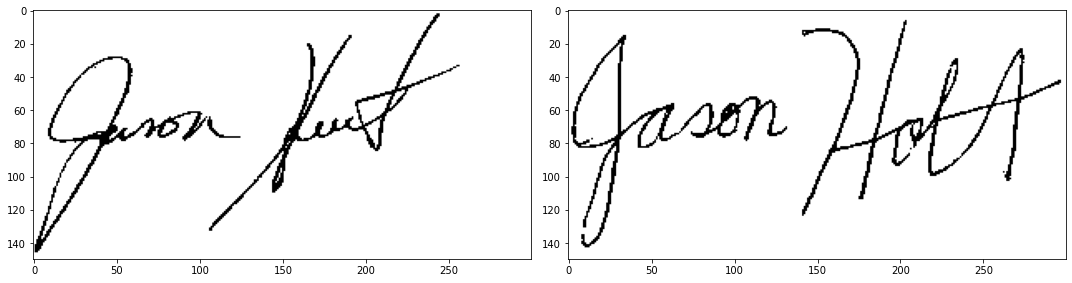

In [ ]:
i = 1

print(targets[i])

plt.figure(figsize = (15, 10))
plt.subplot(121)
plt.imshow(pairs[0][i],'gray')
plt.subplot(122)
plt.imshow(pairs[1][i],'gray')
plt.tight_layout()
plt.show()

### evaluate


In [ ]:
batch_sz = 110
num_samples

46860

In [ ]:
num_samples / batch_sz

426.0

In [ ]:
# while (1):
#   if num_samples % batch_sz == 0:
#     print(batch_sz)
#     break
#   batch_sz = batch_sz+1

In [ ]:
# cedar55
ev = siamese_net.evaluate(
                            generate_batch(orig_groups, forg_groups, batch_size = batch_sz), 
                            steps = num_samples//batch_sz,
                            )
ev

In [ ]:
y_pred = siamese_net.predict(
                                      generate_batch(orig_groups, forg_groups, batch_size = batch_sz), 
                                      steps = num_samples//batch_sz,
                                      verbose=1,
                                      )

426/426 [==============================] - 945s 2s/step


In [ ]:
pickle.dump( y_pred, open(path_y + "y_pred_cedar.pickle",'wb') )

In [ ]:
y_pred = pickle.load(open(path_y + "y_pred_cedar.pickle",'rb'))

In [ ]:
y_pred

array([[7.5739576e-03],
       [1.9321193e-01],
       [3.8610080e-03],
       ...,
       [1.8827435e-05],
       [1.0350917e-01],
       [8.5267800e-01]], dtype=float32)

In [ ]:
# y_pred_round = np.where(y_pred > 0.75, 1, 0).flatten()
y_pred_round = y_pred.round().flatten().astype('int')

In [ ]:
y_true = np.array(y_true)

In [ ]:
y_pred_round

array([0, 0, 0, ..., 0, 0, 1])

In [ ]:
y_true

array([0, 1, 0, ..., 0, 0, 1])

In [ ]:
# data = {}
# data['y_pred'] = y_pred
# data['y_pred_round'] = y_pred_round
# data['y_true'] = y_true

# pickle.dump( data, open(path_y + "y_cedar.pickle",'wb') )

In [33]:
data = pickle.load(open(path_y + "y_cedar.pickle",'rb'))

In [34]:
y_pred_round , y_true = data['y_pred_round'], data['y_true']

In [35]:
y_true.shape, y_true[y_true==0].shape , y_true[y_true==1].shape

((46860,), (31680,), (15180,))

In [ ]:
cm = confusion_matrix(y_true, y_pred_round)
cm

array([[28735,  2945],
       [ 2072, 13108]])

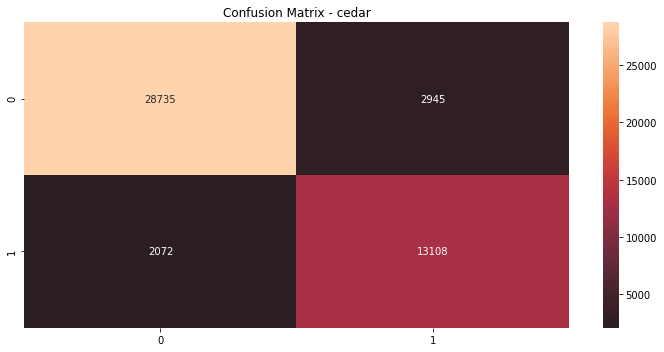

In [ ]:
# drawing confusion matrix
plt.figure(figsize=(10,5))
sns.heatmap(cm, center = True, annot=True, fmt="d")

plt.title('Confusion Matrix - cedar')
plt.tight_layout()

# save the figure
plt.savefig(path_y + "CM_cedar.png")


plt.show()

In [ ]:
accuracy = accuracy_score(y_true, y_pred_round)
print("Accuracy : ", accuracy*100, "%")

Accuracy :  89.29364063166881 %


In [ ]:
print(classification_report(y_true,y_pred_round,output_dict=False))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92     31680
           1       0.82      0.86      0.84     15180

    accuracy                           0.89     46860
   macro avg       0.87      0.89      0.88     46860
weighted avg       0.90      0.89      0.89     46860



In [ ]:
cr = classification_report(y_true, y_pred_round, output_dict=True)
pd.DataFrame(cr).T

,precision,recall,f1-score,support
0,0.932743,0.907039,0.919711,31680.000000
1,0.816545,0.863505,0.839369,15180.000000
accuracy,0.892936,0.892936,0.892936,0.892936
macro avg,0.874644,0.885272,0.879540,46860.000000
weighted avg,0.895101,0.892936,0.893685,46860.000000


In [ ]:
ZeroOneLossValue = zero_one_loss(y_true, y_pred_round, normalize=False)
print('Wrong Value : ', ZeroOneLossValue )
ZeroOneLossValue = zero_one_loss(y_true, y_pred_round, normalize=True)
print('Wrong percentage : ', round(ZeroOneLossValue*100,2), "%" )

Wrong Value :  5017
Wrong percentage :  10.71 %


In [ ]:
fprValue, tprValue, thresholdsValue = roc_curve(y_true, y_pred_round)
print('False Postitve Rate Value : ', fprValue)
print('True Postitve Rate Value Value  : ', tprValue)
print('thresholds Value  : ', thresholdsValue)

False Postitve Rate Value :  [0.         0.09296086 1.        ]
True Postitve Rate Value Value  :  [0.         0.86350461 1.        ]
thresholds Value  :  [2 1 0]


In [ ]:
aucValue = auc(fprValue, tprValue)
aucValue2 = roc_auc_score(y_true, y_pred_round)
print('Area Under the Curve Value  : ', aucValue)
print('Area Under the Curve Value  : ', aucValue2)

Area Under the Curve Value  :  0.8852718763724199
Area Under the Curve Value  :  0.8852718763724199


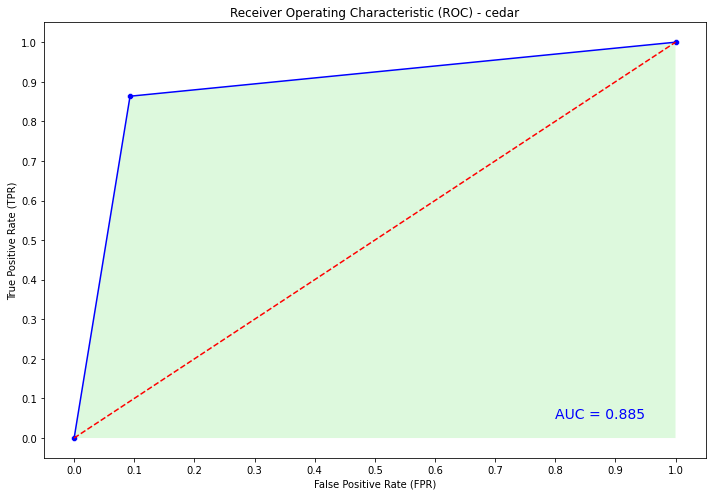

In [ ]:
plt.figure(figsize=(10,7))

sns.lineplot(x=fprValue, y=tprValue, color='blue');
sns.lineplot(x=[0, 1], y=[0, 1], color='red', linestyle='--')
plt.fill_between(fprValue, tprValue, facecolor='lightgreen', alpha=0.3)
plt.text(0.95, 0.05, f"AUC = {aucValue:0.3f}", ha='right', fontsize=14, color='blue')
# plt.scatter(fprValue,tprValue)
sns.scatterplot(x=fprValue, y=tprValue, color='blue', alpha=1);

plt.title('Receiver Operating Characteristic (ROC) - cedar')
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')
plt.xticks(np.arange(0,1.1,0.1))
plt.yticks(np.arange(0,1.1,0.1))

# plt.xlim([0, 1])
# plt.ylim([0, 1])
plt.tight_layout()

# save the figure
plt.savefig(path_y + "ROC_cedar.png")

plt.show() 